In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import re
import gensim.downloader as api

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Uncomment if necessary
# pip install wordcloud
# pip install sentence_transformers

In [3]:
# import preproccessed csv file
df = pd.read_csv('preprocessed_amazon.csv')

In [4]:
# Tokenization and Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Product Title'])

In [5]:
# Tokenization and Vectorization using Word2Vec
tokenized_text = [word_tokenize(text) for text in df['Product Title']]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

In [6]:
# Averaging Word2Vec vectors for each tokenized Title
X_word2vec = []
for text in tokenized_text:
    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        X_word2vec.append(np.mean(vectors, axis=0))
    else:
        X_word2vec.append(np.zeros(word2vec_model.vector_size))  # Use zero vector if no valid words found

X_word2vec = np.array(X_word2vec)

In [7]:
# Fit the KNN model using TF-IDF vectors
knn_tfidf = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf.fit(X_tfidf)

# Fit the KNN model using Word2Vec vectors
knn_word2vec = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_word2vec.fit(X_word2vec)

NearestNeighbors(metric='cosine', n_neighbors=15)

In [8]:
def find_similar_posts(input_text, vectorizer, knn_model, top_k=5):
    if vectorizer == 'tfidf':
        input_vector = tfidf_vectorizer.transform([input_text])
    elif vectorizer == 'word2vec':
        words = word_tokenize(input_text)
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if len(word_vectors) == 0:
            return []
        input_vector = np.mean(word_vectors, axis=0).reshape(1, -1)
    
    if vectorizer == 'tfidf':
        _, indices = knn_tfidf.kneighbors(input_vector, n_neighbors=top_k)
    elif vectorizer == 'word2vec':
        _, indices = knn_word2vec.kneighbors(input_vector, n_neighbors=top_k)
    
    return df.iloc[indices[0]]['Product Title'].tolist()

# Test
input_text = "purple phonecase"
similar_posts_tfidf = find_similar_posts(input_text, 'tfidf', knn_tfidf)
similar_posts_word2vec = find_similar_posts(input_text, 'word2vec', knn_word2vec)

print("Similar posts using TF-IDF:")
for idx, post in enumerate(similar_posts_tfidf, start=1):
    print(f"{idx}. {post}")
    
print("\nSimilar posts using Word2Vec:")
for idx, post in enumerate(similar_posts_word2vec, start=1):
    print(f"{idx}. {post}")

Similar posts using TF-IDF:
1.  Purple : ecoLove Purple Collection Conditioner for colored and very dry hair - Blueberry, Grape & Lavender. 100% VEGAN (17.6 Oz) 
2.  Babila Bleach Brush, Purple 
3.  SUGARIN, Fondust, Purple, 250gm 
4.  Colour Me Eau De Toilette (Purple), 50ml 
5.  SUGARIN Fondust, Purple, 5.5gm 

Similar posts using Word2Vec:
1.  white london 
2.  philosophy pink melon sorbet lip balm 
3.  ddp acrylic nail pincher tool multi function cuticle pusher tweezer magic wand purple 
4.  Generic Purple Female Diamond Flower Frame Presbyopic Reading Glasses Eyeglasses 2.0 
5.  CARO WHITE LIGHTENING BEAUTY SOAP 180g 


In [9]:
glove_model = api.load('glove-wiki-gigaword-100')

# Fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Product Title'])

# Fit the KNN model using TF-IDF vectors
knn_tfidf = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf.fit(X_tfidf)

# Fit the KNN model using GloVe vectors
def get_glove_vector(word):
    try:
        return glove_model[word]
    except KeyError:
        return None

def get_mean_glove_vectors(words):
    vectors = [get_glove_vector(word) for word in words]
    vectors = [vec for vec in vectors if vec is not None]
    if len(vectors) == 0:
        return None
    return np.mean(vectors, axis=0).reshape(1, -1)

def get_glove_vectorized_data(X):
    vectors = [get_mean_glove_vectors(word_tokenize(str(text))) for text in X['Product Title']]
    valid_vectors = [vec for vec in vectors if vec is not None]
    return np.concatenate(valid_vectors) if valid_vectors else np.array([])

X_glove_array = get_glove_vectorized_data(df)
knn_glove = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove.fit(X_glove_array)

def find_similar_posts(input_text, vectorizer, knn_model, top_k=5):
    if vectorizer == 'tfidf':
        input_vector = tfidf_vectorizer.transform([input_text])
    elif vectorizer == 'glove':
        input_vector = get_mean_glove_vectors(word_tokenize(input_text))
        if input_vector is None:
            return []
    
    if vectorizer == 'tfidf':
        _, indices = knn_tfidf.kneighbors(input_vector)
    elif vectorizer == 'glove':
        _, indices = knn_glove.kneighbors(input_vector)
    
    return df.iloc[indices[0]]['Product Title']
# Test
input_text = "purple phonecase"
similar_posts_tfidf = find_similar_posts(input_text, 'tfidf', knn_tfidf)
similar_posts_glove = find_similar_posts(input_text, 'glove', knn_glove)

print("Similar posts using TF-IDF:")
print(similar_posts_tfidf)
print("\nSimilar posts using GloVe:")
print(similar_posts_glove)


Similar posts using TF-IDF:
15091     Purple : ecoLove Purple Collection Conditione...
6225                          Babila Bleach Brush, Purple 
20411                     SUGARIN, Fondust, Purple, 250gm 
998              Colour Me Eau De Toilette (Purple), 50ml 
960                        SUGARIN Fondust, Purple, 5.5gm 
13424          SUGARIN, Ediblle Petal Dust, Purple, 250gm 
6025      Cion Bath Sponge, loofah for bath (Blue & Pur...
7987                Tec Italy - Lumina Purple Conditioner 
14644     SUGARIN, Edible Lustre Dust, Pearl Purple, 20...
20855     Sugarin Icing Color Gel for Fondant, Purple, ...
2037        Fa Purple Passion Sensual Scent roll On 50 ML 
9381      United Colors of Benetton Colours Purple for ...
9791      Golden Cart Chocolate Purple Bouquet (50 Pcs ...
17        Stockout SEPHORA COLLECTION Colorful Shadow &...
13542     Nike Deodorant Combo Of 2 (Purple + Up Or Dow...
Name: Product Title, dtype: object

Similar posts using GloVe:
13930     Suave Invis Sl

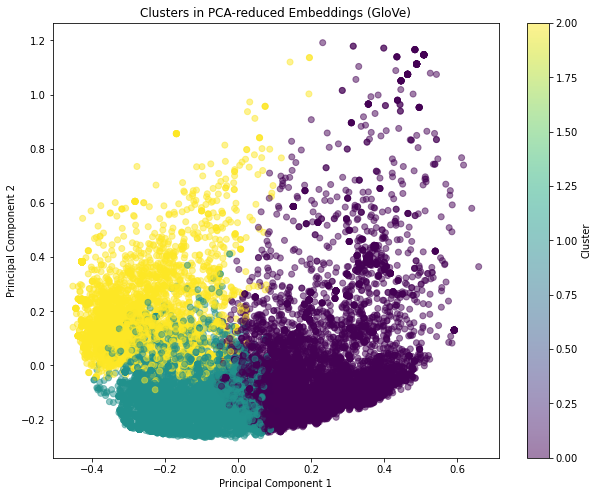

In [10]:
glove_model = api.load('glove-wiki-gigaword-100')

# Vectorize product titles using GloVe embeddings
def get_mean_glove_vector(text):
    words = word_tokenize(text)
    vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else None

X_glove = df['Product Title'].apply(get_mean_glove_vector)
X_glove = np.vstack(X_glove.dropna())

normalized_embeddings = X_glove / np.linalg.norm(X_glove, axis=1, keepdims=True)

kmeans_glove = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_glove = kmeans_glove.fit_predict(normalized_embeddings)

pca_glove = PCA(n_components=3)
compressed_embeddings_glove = pca_glove.fit_transform(normalized_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(compressed_embeddings_glove[:, 0], compressed_embeddings_glove[:, 1], c=clusters_glove, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Clusters in PCA-reduced Embeddings (GloVe)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

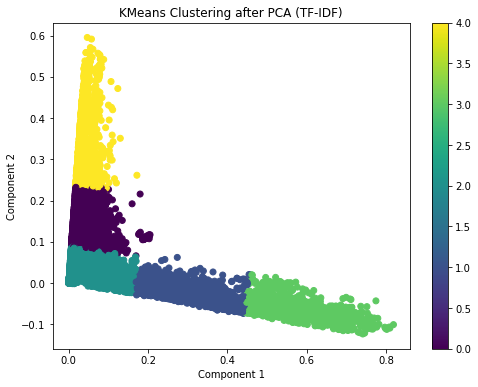

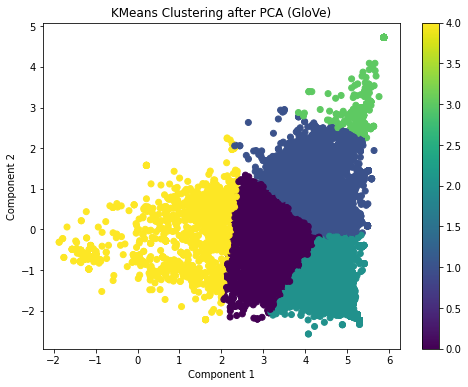

In [11]:
# Perform PCA on TF-IDF vectors
pca = TruncatedSVD(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf)

# Perform PCA on GloVe vectors
X_glove_pca = pca.fit_transform(X_glove)

# Perform KMeans clustering on PCA-transformed TF-IDF vectors
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_pca.fit(X_pca)

# Perform KMeans clustering on PCA-transformed GloVe vectors
kmeans_glove_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_glove_pca.fit(X_glove_pca)

# Visualize the clusters for PCA-transformed TF-IDF vectors
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis')
plt.title('KMeans Clustering after PCA (TF-IDF)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

# Visualize the clusters for PCA-transformed GloVe vectors
plt.figure(figsize=(8, 6))
plt.scatter(X_glove_pca[:, 0], X_glove_pca[:, 1], c=kmeans_glove_pca.labels_, cmap='viridis')
plt.title('KMeans Clustering after PCA (GloVe)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

In [12]:
# Fit the TruncatedSVD (PCA) model
pca = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_pca = pca.fit_transform(X_tfidf)

# Fit the KNN model on the PCA-transformed TF-IDF vectors
knn_tfidf_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf_pca.fit(X_tfidf_pca)

# Define a function to find similar posts using PCA-transformed TF-IDF vectors
def find_similar_posts_tfidf_pca(input_text, top_k=15):
    input_vector = tfidf_vectorizer.transform([input_text])
    input_pca = pca.transform(input_vector)
    _, indices = knn_tfidf_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

# Example usage for PCA-transformed TF-IDF vectors
input_text = "purple phonecase"
similar_posts_tfidf_pca = find_similar_posts_tfidf_pca(input_text)
print("Similar posts using TF-IDF after PCA:")
print(similar_posts_tfidf_pca)

Similar posts using TF-IDF after PCA:
10896     Kaiv Lof2206 Double Color Sponge, Multicolor,...
960                        SUGARIN Fondust, Purple, 5.5gm 
1842      Leemax Disposable Surgical Bouffant Shower Ca...
476       SWEET INSPIRATIONS Edible Cake decoration Spr...
21319              SUGARIN Whipping Color,Navy Blue, 28GM 
4441      Generic 02: Magic Color Jelly AB Diamond DIY ...
22914                                                Blue 
16373     Generic 600Pcs L Makeup Clear Gray Mesh Lace ...
6957      COTTON LABO Multi-Layer Cotton Makeup Puff, 8...
6896           Smarties Double Lollies Lollipops, 1 Pound 
14337     color 3 : 1 Bag Elastic Hair Bands Rubber Hai...
20411                     SUGARIN, Fondust, Purple, 250gm 
1133      ShopUSAIndia Sally Hansen Hard As Nails Xtrem...
5422      shrinika Microfiber Quick-Drying Shower Cap M...
22573     Bleu Make Up/Toiletry Organiser Box Pouch Pur...
Name: Product Title, dtype: object


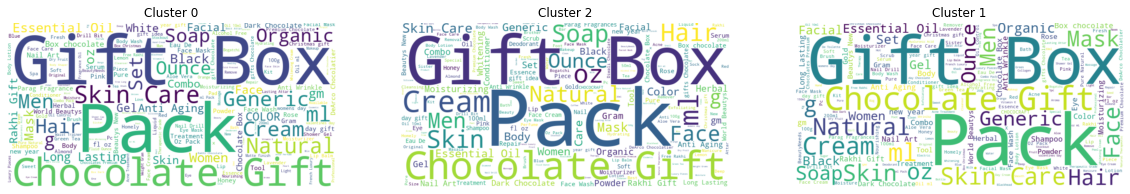

In [13]:
# Create a wordcloud
cluster_texts_glove = defaultdict(str)
for text, label in zip(df['Product Title'], clusters_glove):
    cluster_texts_glove[label] += " " + text

plt.figure(figsize=(20, 10))
for i, (label, text) in enumerate(cluster_texts_glove.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(1, len(cluster_texts_glove), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {label}')
    plt.axis("off")
plt.show()

In [14]:
# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

def get_mean_glove_vectors(words):
    vectors = [glove_model[word] for word in words if word in glove_model]
    if len(vectors) == 0:
        return np.zeros(100)  # Return a zero vector of the same dimension as the GloVe vectors
    return np.mean(vectors, axis=0)

# Vectorize the entire dataset using GloVe embeddings
X_glove = np.array([get_mean_glove_vectors(word_tokenize(text)) for text in df['Product Title']])
X_glove = np.nan_to_num(X_glove)  # Handle NaN values

# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

# Fit the KNN model on the PCA-transformed GloVe vectors
knn_glove_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove_pca.fit(X_glove_pca)

# Define a function to find similar posts using PCA-transformed GloVe vectors
def find_similar_posts_glove_pca(input_text, top_k=15):
    input_vector = get_mean_glove_vectors(word_tokenize(input_text))
    input_vector = input_vector.reshape(1, -1)  
    input_pca = pca_glove.transform(input_vector)
    _, indices = knn_glove_pca.kneighbors(input_pca)
    print(indices)
    return df.iloc[indices[0]]['Product Title']
    
input_text = "purple phonecase"
similar_posts_glove_pca = find_similar_posts_glove_pca(input_text)
print("\nSimilar posts using GloVe after PCA:")
print(similar_posts_glove_pca)

[[16199 15862  1437 18187 20424 14596 13508 22549 18383  3229 21824 20680
  22854  1361 10253]]

Similar posts using GloVe after PCA:
16199     New Popular Facial Face Steamer Pores Cleanse...
15862     Generic 3D Sleep Mask Natural Sleeping Eye Ma...
1437      Homely OldLace Short Color Full Cover Artific...
18187     BAW sky blue : 1Pc Wash Face Makeup SPA Hair ...
20424     World Beautys New Pro Blackhead Remove Facial...
14596     BeautyNeeds 1Pair Moisturize Soften Repair Cr...
13508     Generic Cleaning Face Cleaner Vibrate Waterpr...
22549     Generic purple: 10pcs/lot Colorful Nail Polis...
18383     Generic purple: 4cm Nail Art Colorful Stamper...
3229      Generic Pink : Sunscreen mouth mask masks cot...
21824     Fashionairs Women Fiber Synthetic wavy curly ...
20680     World Beautys New Blackhead Remove Facial Mas...
22854     pink : Face V Shaper Facial Slimming Bandage ...
1361      Generic 6Pcs Disposable Shower Hat Women Spa ...
10253     Generic Florid 36 colors tempo